https://zenodo.org/records/5727800

# imports

In [1]:
!pip install neurokit2 --quiet
!pip install neurokit2 pyhrv --quiet
!pip install pyhrv peakutils --quiet
!pip uninstall -y biosppy pyhrv
!pip install biosppy==0.6.1 pyhrv==0.4.0 --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 696.5/696.5 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.5/231.5 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.0/158.0 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.2/750.2 kB 34.6 MB/s eta 0:00:00
Found existing installation: biosppy 2.2.3
Uninstalling biosppy-2.2.3:
  Successfully uninstalled biosppy-2.2.3
Found existing installation: pyhrv 0.4.1
Uninstalling pyhrv-0.4.1:
  Successfully uninstalled pyhrv-0.4.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 35.6 MB/s eta 0:00:00


In [2]:
import neurokit2 as nk
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import zscore
from scipy.integrate import trapezoid
from scipy.interpolate import interp1d
from scipy.signal import welch
from tensorflow import keras
from pyhrv.frequency_domain import welch_psd
from pyhrv.nonlinear import sample_entropy

# upload data from drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')
import os
import keras
import joblib

project_dir = '/content/drive/MyDrive/Colab Notebooks/project/'
trained_models_dir = os.path.join(project_dir, 'trained models/')

# Check if the file exists before attempting to load
hrv_model_path = trained_models_dir+"stress models/keras/stress_from_hrv_model_up.keras"

s_from_hrv_model = keras.models.load_model(trained_models_dir+"stress models/keras/stress_model_up.keras")
s_from_step_model = keras.models.load_model(trained_models_dir+"stress models/keras/stress_from_steps_model.keras")
s_from_ox_model = keras.models.load_model(trained_models_dir+"stress models/keras/stress_from_sleep_and_ox_model.keras")

scaler_steps = joblib.load(trained_models_dir+"stress models/pkl/steps_scaler.pkl")
scaler_oxsleep = joblib.load(trained_models_dir+"stress models/pkl/ox_and_sleep_scaler.pkl")
scaler_hrv = joblib.load(trained_models_dir+'stress models/pkl/hrv_scaler.pkl')

encoder_hrv = joblib.load(trained_models_dir+'stress models/hrv_encoder.pkl')

Mounted at /content/drive


#sanity cheack for stress models

In [4]:
'''# downloading csv with extra, no need to run again
test_dir = project_dir+"Integration and simulation/test.csv"
test_df = pd.read_csv(test_dir)
test_extra_df = test_df.copy()


test_extra_df["blood_oxygen"] = np.round(np.random.uniform(90.0, 99.0, size=len(df)), 1)

test_extra_df["sleeping_hours"] = np.round(np.random.uniform(0.0, 9.0, size=len(df)), 1)

test_extra_df["step_count"] = np.random.randint(0, 200, size=len(df))

new_test_path = project_dir + "Integration and simulation/test_with_extra.csv"
test_extra_df.to_csv(new_test_path, index=False)

SyntaxError: incomplete input (<ipython-input-4-da1a77c6aedc>, line 1)

In [5]:
new_test_path = project_dir + "Integration and simulation/test_with_extra.csv"
test_extra_df = pd.read_csv(new_test_path)
df = test_extra_df.copy()
print(df.head())
print(df.columns)

      MEAN_RR   MEDIAN_RR        SDRR      RMSSD       SDSD  SDRR_RMSSD  \
0  721.901897  727.267280   74.722315  12.361264  12.361069    6.044877   
1  843.538633  844.407930   58.499429  19.298880  19.298795    3.031234   
2  958.523868  966.671125  132.849110  21.342715  21.342653    6.224565   
3  824.838669  842.485905  117.822094  11.771814  11.771248   10.008830   
4  756.707933  747.941620  143.968457  13.357748  13.356388   10.777899   

          HR      pNN25     pNN50        SD1  ...           TP       LF_HF  \
0  84.121868   4.933333  0.000000   8.743513  ...  1698.605390    9.245599   
1  71.478642  21.000000  0.200000  13.650863  ...  2358.884694   59.126832   
2  63.874293  24.133333  1.800000  15.096571  ...  4328.633724  129.477524   
3  74.330531   4.733333  0.533333   8.326307  ...  2854.449091   28.773854   
4  82.092049   5.933333  0.666667   9.447545  ...  5310.027472   14.892559   

      HF_LF    sampen    higuci  datasetId      condition  blood_oxygen  \
0  0.

In [6]:
print(df.groupby('datasetId').size())

datasetId
2    41033
dtype: int64


In [7]:
def extract_features_by_index(df, index):

    columns = [
        'MEAN_RR', 'MEDIAN_RR', 'SDRR', 'RMSSD', 'SDSD', 'SDRR_RMSSD', 'HR',
        'pNN25', 'pNN50', 'SD1', 'SD2', 'KURT', 'SKEW', 'MEAN_REL_RR',
        'MEDIAN_REL_RR', 'SDRR_REL_RR', 'RMSSD_REL_RR', 'SDSD_REL_RR',
        'SDRR_RMSSD_REL_RR', 'KURT_REL_RR', 'SKEW_REL_RR', 'VLF', 'VLF_PCT',
        'LF', 'LF_PCT', 'LF_NU', 'HF', 'HF_PCT', 'HF_NU', 'TP', 'LF_HF',
        'HF_LF', 'sampen', 'higuci', 'blood_oxygen',
        'sleeping_hours', 'step_count'
    ]

    if index not in df.index:
        raise IndexError(f"Index {index} is not in the DataFrame.")

    return df.loc[index, columns]


In [8]:
result = extract_features_by_index(df, 4)
print(result)


MEAN_RR               756.707933
MEDIAN_RR              747.94162
SDRR                  143.968457
RMSSD                  13.357748
SDSD                   13.356388
SDRR_RMSSD             10.777899
HR                     82.092049
pNN25                   5.933333
pNN50                   0.666667
SD1                     9.447545
SD2                   203.382835
KURT                    1.134111
SKEW                    0.769517
MEAN_REL_RR              0.00031
MEDIAN_REL_RR           -0.00017
SDRR_REL_RR             0.019649
RMSSD_REL_RR            0.011689
SDSD_REL_RR             0.011689
SDRR_RMSSD_REL_RR       1.681034
KURT_REL_RR             1.134111
SKEW_REL_RR             0.769517
VLF                  4750.624447
VLF_PCT                89.465158
LF                    524.203971
LF_PCT                  9.871963
LF_NU                  93.707747
HF                     35.199054
HF_PCT                  0.662879
HF_NU                   6.292253
TP                   5310.027472
LF_HF     

In [9]:
import numpy as np

def predict_stress_levels(features_row):

    if not isinstance(features_row, (pd.Series, dict)):
        raise ValueError("Input must be a pandas Series or dict-like structure.")

    # HRV model input features
    hrv_features = [
        'MEAN_RR', 'MEDIAN_RR', 'SDRR', 'RMSSD', 'SDSD', 'SDRR_RMSSD', 'HR',
        'pNN25', 'pNN50', 'SD1', 'SD2', 'KURT', 'SKEW', 'MEAN_REL_RR',
        'MEDIAN_REL_RR', 'SDRR_REL_RR', 'RMSSD_REL_RR', 'SDSD_REL_RR',
        'SDRR_RMSSD_REL_RR', 'KURT_REL_RR', 'SKEW_REL_RR', 'VLF', 'VLF_PCT',
        'LF', 'LF_PCT', 'LF_NU', 'HF', 'HF_PCT', 'HF_NU', 'TP', 'LF_HF',
        'HF_LF', 'sampen', 'higuci'
    ]

    step_features = ['step_count']
    oxsleep_features = ['blood_oxygen', 'sleeping_hours']

    # Convert features to named DataFrames to insure corect features order
    hrv_df = pd.DataFrame([features_row[hrv_features]], columns=hrv_features)


    # Extract and scale features
    hrv_input = scaler_hrv.transform(hrv_df)
    hrv_input = np.expand_dims(hrv_input, axis=1)
    step_input = scaler_steps.transform([[features_row['step_count']]])
    oxsleep_input = scaler_oxsleep.transform([features_row[oxsleep_features].values])

    # Make predictions
    stress_from_hrv = np.argmax(s_from_hrv_model.predict(hrv_input, verbose=0)[0])
    stress_from_steps = np.argmax(s_from_step_model.predict(step_input, verbose=0)[0])
    stress_from_ox = np.argmax(s_from_ox_model.predict(oxsleep_input, verbose=0)[0])

    return {
        "stress_from_hrv": stress_from_hrv,
        "stress_from_steps": stress_from_steps,
        "stress_from_oxsleep": stress_from_ox,
        "stress_total": 1.5*stress_from_hrv + 0.5*stress_from_steps + 0.5*stress_from_ox
    }


In [10]:
features = extract_features_by_index(df, 4)
predictions = predict_stress_levels(features)
print(predictions)


{'stress_from_hrv': np.int64(0), 'stress_from_steps': np.int64(2), 'stress_from_oxsleep': np.int64(1), 'stress_total': np.float64(1.5)}


In [11]:
results = []

for idx in range(0, 200):
    features = extract_features_by_index(df, idx)
    predicted_classes = predict_stress_levels(features)
    predicted_classes["index"] = idx  # Track which row this came from
    results.append(predicted_classes)

# Convert to DataFrame for easy viewing
results_df = pd.DataFrame(results)

print(results_df)


     stress_from_hrv  stress_from_steps  stress_from_oxsleep  stress_total  \
0                  1                  2                    1           3.0   
1                  2                  1                    1           4.0   
2                  1                  0                    3           3.0   
3                  1                  0                    2           2.5   
4                  0                  2                    1           1.5   
..               ...                ...                  ...           ...   
195                0                  1                    3           2.0   
196                1                  0                    1           2.0   
197                0                  2                    3           2.5   
198                2                  1                    1           4.0   
199                1                  2                    3           4.0   

     index  
0        0  
1        1  
2        2  
3        3 

In [12]:
print("Grouped by stress_from_hrv:")
print(results_df.groupby('stress_from_hrv').size())

print("\nGrouped by stress_from_steps:")
print(results_df.groupby('stress_from_steps').size())

print("\nGrouped by stress_from_oxsleep:")
print(results_df.groupby('stress_from_oxsleep').size())

print("\nGrouped by stress_total:")
print(results_df.groupby('stress_total').size())

Grouped by stress_from_hrv:
stress_from_hrv
0     66
1    108
2     26
dtype: int64

Grouped by stress_from_steps:
stress_from_steps
0    73
1    66
2    61
dtype: int64

Grouped by stress_from_oxsleep:
stress_from_oxsleep
0      4
1    108
2     40
3     42
4      6
dtype: int64

Grouped by stress_total:
stress_total
0.0     1
0.5    16
1.0    14
1.5    22
2.0    33
2.5    28
3.0    30
3.5    24
4.0    17
4.5    11
5.0     3
5.5     1
dtype: int64


In [13]:
import numpy as np
import pandas as pd

def add_stress_predictions(df):
    # Feature lists
    hrv_features = [
        'MEAN_RR', 'MEDIAN_RR', 'SDRR', 'RMSSD', 'SDSD', 'SDRR_RMSSD', 'HR',
        'pNN25', 'pNN50', 'SD1', 'SD2', 'KURT', 'SKEW', 'MEAN_REL_RR',
        'MEDIAN_REL_RR', 'SDRR_REL_RR', 'RMSSD_REL_RR', 'SDSD_REL_RR',
        'SDRR_RMSSD_REL_RR', 'KURT_REL_RR', 'SKEW_REL_RR', 'VLF', 'VLF_PCT',
        'LF', 'LF_PCT', 'LF_NU', 'HF', 'HF_PCT', 'HF_NU', 'TP', 'LF_HF',
        'HF_LF', 'sampen', 'higuci'
    ]
    oxsleep_features = ['blood_oxygen', 'sleeping_hours']
    step_feature = ['step_count']

    # Prepare DataFrames for scaling
    hrv_df = df[hrv_features]
    oxsleep_df = df[oxsleep_features]
    step_df = df[step_feature]

    # Scale inputs
    hrv_input = scaler_hrv.transform(hrv_df)
    hrv_input = np.expand_dims(hrv_input, axis=1)

    oxsleep_input = scaler_oxsleep.transform(oxsleep_df.values)


    step_input = scaler_steps.transform(step_df.values)


    # Predict class labels
    stress_from_hrv = np.argmax(s_from_hrv_model.predict(hrv_input, verbose=0), axis=1)
    stress_from_steps = np.argmax(s_from_step_model.predict(step_input, verbose=0), axis=1)
    stress_from_ox = np.argmax(s_from_ox_model.predict(oxsleep_input, verbose=0), axis=1)

    # Add columns to DataFrame
    df["stress_from_hrv"] = stress_from_hrv
    df["stress_from_steps"] = stress_from_steps
    df["stress_from_oxsleep"] = stress_from_ox
    df["stress_total"] = 1.5 * stress_from_hrv + 0.5 * stress_from_steps + 0.5 * stress_from_ox

    return df


In [14]:
df = add_stress_predictions(df)
print(df[["stress_from_hrv", "stress_from_steps", "stress_from_oxsleep", "stress_total"]].head())


   stress_from_hrv  stress_from_steps  stress_from_oxsleep  stress_total
0                1                  2                    1           3.0
1                2                  1                    1           4.0
2                1                  0                    3           3.0
3                1                  0                    2           2.5
4                0                  2                    1           1.5


In [15]:
def get_emotion(stress_value):
    if stress_value >= 3.5:
        return "anger"
    elif stress_value >= 2.5:
        return "sad"
    elif stress_value >= 2:
        return "happy"
    else:
        return "relaxed"

In [16]:
# Apply the function to the 'stress_total' column
df['emotion'] = df['stress_total'].apply(get_emotion)

In [ ]:
''' # downloading final csv, no need to run again
results_path = project_dir + "Integration and simulation/test_with_results.csv"
df.to_csv(results_path, index=False)

# Emotion service simple


In [17]:
results_path = project_dir + "Integration and simulation/test_with_results.csv"
result_df = pd.read_csv(results_path)
result_csv = result_df.copy()

print(result_csv.head())
print(result_csv.columns)
print(result_csv.shape)

      MEAN_RR   MEDIAN_RR        SDRR      RMSSD       SDSD  SDRR_RMSSD  \
0  721.901897  727.267280   74.722315  12.361264  12.361069    6.044877   
1  843.538633  844.407930   58.499429  19.298880  19.298795    3.031234   
2  958.523868  966.671125  132.849110  21.342715  21.342653    6.224565   
3  824.838669  842.485905  117.822094  11.771814  11.771248   10.008830   
4  756.707933  747.941620  143.968457  13.357748  13.356388   10.777899   

          HR      pNN25     pNN50        SD1  ...  datasetId      condition  \
0  84.121868   4.933333  0.000000   8.743513  ...          2      no stress   
1  71.478642  21.000000  0.200000  13.650863  ...          2  time pressure   
2  63.874293  24.133333  1.800000  15.096571  ...          2      no stress   
3  74.330531   4.733333  0.533333   8.326307  ...          2      no stress   
4  82.092049   5.933333  0.666667   9.447545  ...          2   interruption   

   blood_oxygen  sleeping_hours  step_count  stress_from_hrv  \
0         

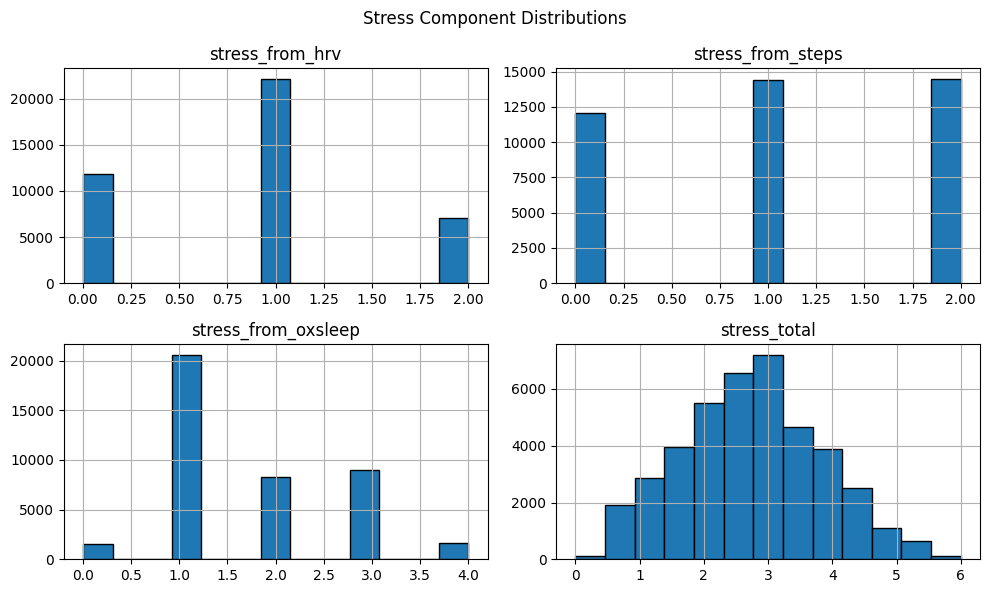

In [18]:
import matplotlib.pyplot as plt

# Select the relevant columns
columns_to_plot = ['stress_from_hrv', 'stress_from_steps',
                   'stress_from_oxsleep', 'stress_total']

# Plot histograms
result_csv[columns_to_plot].hist(bins=13, figsize=(10, 6), edgecolor='black')

plt.suptitle("Stress Component Distributions")
plt.tight_layout()
plt.show()


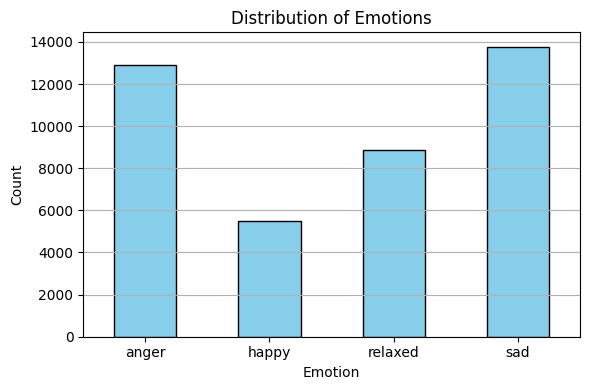

In [19]:
import matplotlib.pyplot as plt

# Count frequency of each emotion
emotion_counts = result_csv['emotion'].value_counts().sort_index()

# Plot as bar chart
plt.figure(figsize=(6, 4))
emotion_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title("Distribution of Emotions")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.grid(axis='y')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [20]:
'''import numpy as np
import pandas as pd

class EmotionService:
    def __init__(self, result_csv):
        self.result_csv = result_csv

    def examine_row_results(self, row_idx):
        columns = [
            "stress_from_hrv", "stress_from_steps", "stress_from_oxsleep", "stress_total",
            "blood_oxygen", "sleeping_hours", "step_count"
        ]
        if row_idx not in self.result_csv.index:
            raise IndexError(f"Row index {row_idx} is not in the DataFrame.")

        return self.result_csv.loc[row_idx, columns]

    def detect(self, row_idx):
        stress_value = self.result_csv.loc[row_idx, "stress_total"]

        if stress_value >= 3.5:
            emotion = "anger"
        elif stress_value >= 2.5:
            emotion = "sad"
        elif stress_value >= 2:
            emotion = "happy"
        else:
            emotion = "relaxed"

        print(f"✅ Detected emotion: {emotion}")
        return emotion'''

'import numpy as np\nimport pandas as pd\n\nclass EmotionService:\n    def __init__(self, result_csv):\n        self.result_csv = result_csv\n\n    def examine_row_results(self, row_idx):\n        columns = [\n            "stress_from_hrv", "stress_from_steps", "stress_from_oxsleep", "stress_total",\n            "blood_oxygen", "sleeping_hours", "step_count"\n        ]\n        if row_idx not in self.result_csv.index:\n            raise IndexError(f"Row index {row_idx} is not in the DataFrame.")\n\n        return self.result_csv.loc[row_idx, columns]\n\n    def detect(self, row_idx):\n        stress_value = self.result_csv.loc[row_idx, "stress_total"]\n\n        if stress_value >= 3.5:\n            emotion = "anger"\n        elif stress_value >= 2.5:\n            emotion = "sad"\n        elif stress_value >= 2:\n            emotion = "happy"\n        else:\n            emotion = "relaxed"\n\n        print(f"✅ Detected emotion: {emotion}")\n        return emotion'

In [23]:
import numpy as np
import pandas as pd

class EmotionService:
    def __init__(self, result_csv):
        self.result_csv = result_csv

    def examine_row_results(self, row_idx):
        columns = [
            "stress_from_hrv", "stress_from_steps", "stress_from_oxsleep", "stress_total",
            "blood_oxygen", "sleeping_hours", "step_count"
        ]
        if row_idx not in self.result_csv.index:
            raise IndexError(f"Row index {row_idx} is not in the DataFrame.")
        return self.result_csv.loc[row_idx, columns]

    def detect(self, row_idx=None):
        # If no index is provided, select a random row
        if row_idx is None:
            row_idx = np.random.choice(self.result_csv.index)

        stress_value = self.result_csv.loc[row_idx, "stress_total"]

        if stress_value >= 3.5:
            emotion = "anger"
        elif stress_value >= 2.5:
            emotion = "sad"
        elif stress_value >= 2:
            emotion = "happy"
        else:
            emotion = "relaxed"

        print(f"✅ Detected emotion: {emotion} (row {row_idx}, stress={stress_value})")
        return emotion


In [24]:
service = EmotionService(result_csv)
row_info = service.examine_row_results(100)
emotion = service.detect(100)

print(emotion)
print(row_info)

✅ Detected emotion: happy
stress_from_hrv           0
stress_from_steps         1
stress_from_oxsleep       3
stress_total            2.0
blood_oxygen           96.9
sleeping_hours          5.6
step_count               71
Name: 100, dtype: object


# emotion models

In [ ]:
print(trained_models_dir)

/content/drive/MyDrive/Colab Notebooks/project/trained models/


In [ ]:
emo_df = pd.read_csv("/content/drive/MyDrive/project/hrv_features_to_emotions.csv")
emo_df["blood_oxygen"] = np.round(np.random.uniform(90.0, 99.0, size=len(emo_df)), 1)
emo_df["sleeping_hours"] = np.round(np.random.uniform(0.0, 9.0, size=len(emo_df)), 1)
emo_df["step_count"] = np.round(np.random.randint(0, 2000, size=len(emo_df)), 1)


In [ ]:
happy_from_hrv_model = keras.models.load_model(trained_models_dir+"emotion models/keras/happy_from_hrv_model.keras")
sad_from_hrv_model = keras.models.load_model(trained_models_dir+"emotion models/keras/sad_from_hrv_model.keras")
anger_from_hrv_model = keras.models.load_model(trained_models_dir+"emotion models/keras/anger_from_hrv_model.keras")
neutral_from_hrv_model = keras.models.load_model(trained_models_dir+"emotion models/keras/neutral_from_hrv_model.keras")

In [ ]:
import joblib

scaler_happy = joblib.load(trained_models_dir+"emotion models/pkl/happy_from_hrv_scaler.pkl")
scaler_sad = joblib.load(trained_models_dir+"emotion models/pkl/sad_from_hrv_scaler.pkl")
scaler_anger = joblib.load(trained_models_dir+"emotion models/pkl/anger_from_hrv_scaler.pkl")
scaler_neutral = joblib.load(trained_models_dir+"emotion models/pkl/neutral_from_hrv_scaler.pkl")

In [ ]:
import numpy as np

def predict_emotion_levels(features_row):

    if not isinstance(features_row, (pd.Series, dict)):
        raise ValueError("Input must be a pandas Series or dict-like structure.")

    # HRV model input features
    hrv_features = [
        'MEAN_RR', 'MEDIAN_RR', 'SDRR', 'RMSSD', 'SDSD', 'SDRR_RMSSD', 'HR',
        'pNN25', 'pNN50', 'SD1', 'SD2', 'KURT', 'SKEW', 'MEAN_REL_RR',
        'MEDIAN_REL_RR', 'SDRR_REL_RR', 'RMSSD_REL_RR', 'SDSD_REL_RR',
        'SDRR_RMSSD_REL_RR', 'KURT_REL_RR', 'SKEW_REL_RR', 'VLF', 'VLF_PCT',
        'LF', 'LF_PCT', 'LF_NU', 'HF', 'HF_PCT', 'HF_NU', 'TP', 'LF_HF',
        'HF_LF', 'sampen', 'higuci'
    ]


    # inputs
    happy_input = scaler_happy.transform([features_row[hrv_features].values])
    sad_input = scaler_sad.transform([features_row[hrv_features].values])
    anger_input = scaler_anger.transform([features_row[hrv_features].values])
    neutral_input = scaler_neutral.transform([features_row[hrv_features].values])

    # Predict emotions levels class (0 to 4)
    happy_level = np.argmax(happy_from_hrv_model.predict(happy_input, verbose=0)[0])
    sad_level = np.argmax(sad_from_hrv_model.predict(happy_input, verbose=0)[0])
    anger_level = np.argmax(anger_from_hrv_model.predict(happy_input, verbose=0)[0])
    neutral_level = np.argmax(neutral_from_hrv_model.predict(happy_input, verbose=0)[0])

    return {
        "happy_level": happy_level,
        "sad_level": sad_level,
        "anger_level": anger_level,
        "neutral_level": neutral_level

    }

In [ ]:
emo_features = extract_features_by_index(emo_df, 5)
emo_predictions = predict_emotion_levels(emo_features)
print(emo_predictions)

{'happy_level': np.int64(0), 'sad_level': np.int64(0), 'anger_level': np.int64(4), 'neutral_level': np.int64(0)}


In [ ]:
emo_results = []

for idx in range(0, 400):
    features = extract_features_by_index(df, idx)
    result = predict_emotion_levels(features)
    result["index"] = idx
    emo_results.append(result)
    print(idx)

emo_results_df = pd.DataFrame(emo_results)
print(emo_results_df)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
print("Grouped by happy:")
print(emo_results_df.groupby('happy_level').size())

print("\nGrouped by sad:")
print(emo_results_df.groupby('sad_level').size())

print("\nGrouped by anger:")
print(emo_results_df.groupby('anger_level').size())

print("\nGrouped by neutral:")
print(emo_results_df.groupby('neutral_level').size())

Grouped by happy:
happy_level
0    400
dtype: int64

Grouped by sad:
sad_level
0    400
dtype: int64

Grouped by anger:
anger_level
0    400
dtype: int64

Grouped by neutral:
neutral_level
0    400
dtype: int64


In [ ]:
'''import numpy as np

def predict_emotions_from_hrv(sub, seg, df):
    try:
        # Extract all 34 HRV features
        features = generate_features_for_row(sub=sub, seg=seg, df=df)
        hrv_features = features[:34]

        x = np.array([hrv_features])

        # Apply appropriate scalers
        x_happy = scaler_happy.transform(x)
        x_sad = scaler_sad.transform(x)
        x_anger = scaler_anger.transform(x)
        x_neutral = scaler_neutral.transform(x)

        # Predict class probabilities
        happy_probs = happy_from_hrv_model.predict(x_happy)
        sad_probs = sad_from_hrv_model.predict(x_sad)
        anger_probs = anger_from_hrv_model.predict(x_anger)
        neutral_probs = neutral_from_hrv_model.predict(x_neutral)

        # Convert to class labels (0–4)
        happy_class = int(np.argmax(happy_probs))
        sad_class = int(np.argmax(sad_probs))
        anger_class = int(np.argmax(anger_probs))
        neutral_class = int(np.argmax(neutral_probs))


        return {
            "Happy": happy_class,
            "Sad": sad_class,
            "Anger": anger_class,
            "Neutral": neutral_class
        }

    except Exception as e:
        print(f"Emotion prediction error for sub={sub}, seg={seg}: {e}")
        return None

In [ ]:
result = predict_emotions_from_hrv(sub=10, seg=3, df=df)
print(result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
{'Happy': 0, 'Sad': 0, 'Anger': 0, 'Neutral': 0}


In [ ]:
# Create empty columns to store predictions
df["Happy_from_HRV"] = np.nan
df["Sad_from_HRV"] = np.nan
df["Anger_from_HRV"] = np.nan
df["Neutral_from_HRV"] = np.nan

# Loop over all rows
for idx, row in df.iterrows():
    sub = row["sub"]
    seg = row["seg"]

    emo_predictions = predict_emotions_from_hrv(sub, seg, df)

    if predictions:
        df.at[idx, "Stress_from_HRV"] = predictions["Stress_from_HRV"]
        df.at[idx, "Stress_from_Steps"] = predictions["Stress_from_Steps"]
        df.at[idx, "Stress_from_OxSleep"] = predictions["Stress_from_OxSleep"]
        df.at[idx, "Total Stress"] = predictions["Total Stress"]
    else:
        print(f"Skipped prediction for sub={sub}, seg={seg}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

In [ ]:
df.groupby('Happy_from_HRV').size()


,0
Happy_from_HRV,


In [ ]:
df.groupby('Sad_from_HRV').size()


,0
Sad_from_HRV,


In [ ]:
df.groupby('Anger_from_HRV').size()


,0
Anger_from_HRV,


In [ ]:
df.groupby('Neutral_from_HRV').size()

,0
Neutral_from_HRV,
